For these tests we will solve an 100x100 system of linear differential equations. This will demonstrate the efficiency of the methods for handling large systems. We will be mostly looking at the efficiency of the work-horse Dormand-Prince Order 4/5 Pairs: one from DifferentialEquations.jl (`DP5`, one from ODE.jl `rk45`, and one from ODEInterface: Hairer's famous `dopri5`). 

Also included is `Tsit5`. While all other ODE programs have gone with the traditional choice of using the Dormand-Prince 4/5 pair as the default, DifferentialEquations.jl uses `Tsit5` as one of the default algorithms. It's a very new (2011) and not widely known, but the theory and the implimentation shows it's more efficient than DP5. Thus we include it just to show off how re-designing a library from the ground up in a language for rapid code and rapid development has its advantages.

In [1]:
using DifferentialEquations, Plots
gr()
# 2D Linear ODE
f = (t,u,du) -> begin
  for i in 1:length(u)
    du[i] = 1.01*u[i]
  end
end
analytic = (t,u₀) -> u₀*exp(1.01*t)
tspan = (0.0,10.0)
prob = ODETestProblem(f,rand(100,100),analytic,tspan)

abstols = 1./10.^(3:13)
reltols = 1./10.^(0:10);

### Speed Baseline

First a baseline. These settings make DifferentialEquations match the Hairer algorithm. Extra saving features are turned off to put DifferentialEquations.jl in "speed mode".

In [3]:
setups = [Dict(:alg=>DP5)
          Dict(:alg=>rk45)
          Dict(:alg=>dopri5)
          Dict(:alg=>Tsit5)]
names = ["DifferentialEquations";"ODE";"ODEInterface";"DifferentialEquations Tsit5"]
wp = ode_workprecision_set(prob,abstols,reltols,setups;names=names,dense=false,save_timeseries=false)
plot(wp)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10 
 
 
 - 
 
 
 6 
 
 
 10 
 
 
 - 
 
 
 4 
 
 
 10 
 
 
 - 
 
 
 2 
 
 
 10 
 
 
 0 
 
 
 10 
 
 
 2 
 
 
 10 
 
 
 - 
 
 
 2 
 
 
 10 
 
 
 - 
 
 
 1 
 
 
 Error 
 
 
 Time (s) 
 
 
 
 
 
 
 
 
 
 DifferentialEquations 
 
 
 
 ODE 
 
 
 
 ODEInterface 
 
 
 
 DifferentialEquations Tsit5

DifferentialEquations.jl has is clearly far in the lead, being more than an order of magnitude faster for the same amount of error.

### Full Saving

Now if we include full saving at every timestep, we receive the following:

In [6]:
setups = [Dict(:alg=>DP5)
          Dict(:alg=>rk45)
          Dict(:alg=>dopri5)
          Dict(:alg=>Tsit5)]
names = ["DifferentialEquations";"ODE";"ODEInterface";"DifferentialEquations Tsit5"]
wp = ode_workprecision_set(prob,abstols,reltols,setups;names=names,dense=false)
plot(wp)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10 
 
 
 - 
 
 
 6 
 
 
 10 
 
 
 - 
 
 
 4 
 
 
 10 
 
 
 - 
 
 
 2 
 
 
 10 
 
 
 0 
 
 
 10 
 
 
 2 
 
 
 10 
 
 
 - 
 
 
 2 
 
 
 10 
 
 
 - 
 
 
 1 
 
 
 Error 
 
 
 Time (s) 
 
 
 
 
 
 
 
 
 
 DifferentialEquations 
 
 
 
 ODE 
 
 
 
 ODEInterface 
 
 
 
 DifferentialEquations Tsit5

While not as dramatic as before, DifferentialEquations.jl is still far in the lead. Since the times are log scaled, this comes out to be almost a 10x lead over ODEInterface, and about a 50x lead over ODE.jl at default tolerances.

### Continuous Output

Now we include continuous output. This has a large overhead because at every timepoint the matrix of rates `k` has to be deep copied. This feature is also only in DifferentialEquations.jl, but leads to the nice `sol(t)` output.

In [7]:
setups = [Dict(:alg=>DP5)
          Dict(:alg=>rk45)
          Dict(:alg=>dopri5)
          Dict(:alg=>Tsit5)]
names = ["DifferentialEquations";"ODE";"ODEInterface";"DifferentialEquations Tsit5"]
wp = ode_workprecision_set(prob,abstols,reltols,setups;names=names)
plot(wp)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10 
 
 
 - 
 
 
 6 
 
 
 10 
 
 
 - 
 
 
 4 
 
 
 10 
 
 
 - 
 
 
 2 
 
 
 10 
 
 
 0 
 
 
 10 
 
 
 2 
 
 
 10 
 
 
 - 
 
 
 2 
 
 
 10 
 
 
 - 
 
 
 1 
 
 
 Error 
 
 
 Time (s) 
 
 
 
 
 
 
 
 
 
 DifferentialEquations 
 
 
 
 ODE 
 
 
 
 ODEInterface 
 
 
 
 DifferentialEquations Tsit5

As you can see, even with this large overhead, DifferentialEquations.jl essentially ties with ODEInterface. This shows that the fully featured `DP5` solver holds its own with even the classic "great" methods.

### Other Runge-Kutta Algorithms

Now let's test it against a smattering of other Runge-Kutta algorithms. First we will test it with all overheads off. Let's do the Order 5 (and the 2/3 pair) algorithms:


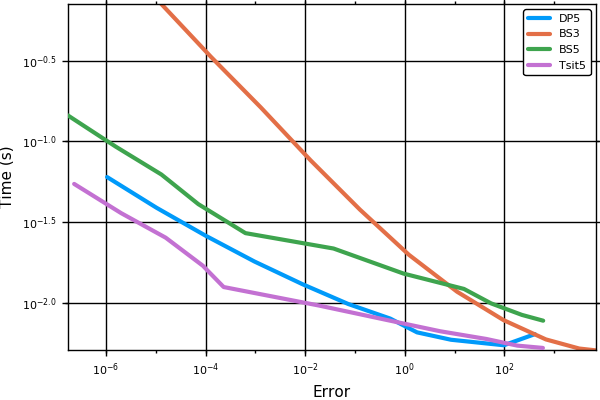

In [7]:
setups = [Dict(:alg=>DP5)
          Dict(:alg=>BS3)
          Dict(:alg=>BS5)
          Dict(:alg=>Tsit5)]
wp = ode_workprecision_set(prob,abstols,reltols,setups;dense=false,save_timeseries=false)
plot(wp)

As you can see, the `Tsit5` algorithm is the most efficient, beating `DP5` which is more efficient than the Bogacki-Shampine algorithms. 

## Higher Order

Now let's see how it fairs against some higher order algorithms:

In [12]:
setups = [Dict(:alg=>DP5)       
          Dict(:alg=>Vern6)
          Dict(:alg=>TanYam7)
          Dict(:alg=>Vern7)
          Dict(:alg=>Vern8)
          Dict(:alg=>DP8)
          Dict(:alg=>Vern9)]
wp = ode_workprecision_set(prob,abstols,reltols,setups;dense=false,save_timeseries=false)
plot(wp)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10 
 
 
 - 
 
 
 5 
 
 
 10 
 
 
 0 
 
 
 10 
 
 
 - 
 
 
 2 
 
 
 10 
 
 
 - 
 
 
 1 
 
 
 Error 
 
 
 Time (s) 
 
 
 
 
 
 
 
 
 
 
 
 
 DiffEqBase.DP5 
 
 
 
 DiffEqBase.Vern6 
 
 
 
 DiffEqBase.TanYam7 
 
 
 
 DiffEqBase.Vern7 
 
 
 
 DiffEqBase.Vern8 
 
 
 
 DiffEqBase.DP8 
 
 
 
 DiffEqBase.Vern9

Vern7 looks to be the winner here, with DP5 doing well at higher tolerances but trailing of when it gets lower as one would expect with lower order algorithms. Some of the higher order methods, such as `Vern9`, would do better at lower tolerances than what's tested (outside of floating point range).

## Higher Order Against Other Packages

Now we test this against the high order methods of the other packages:

In [2]:
setups = [Dict(:alg=>DP5)       
          Dict(:alg=>Vern7)
          Dict(:alg=>dop853)
          Dict(:alg=>feh78)
          Dict(:alg=>CVODE_Adams)]    
wp = ode_workprecision_set(prob,abstols,reltols,setups;dense=false,save_timeseries=false)
plot(wp)

[DifferentialEquations.jl] Initializing backend: ODEInterface
[DifferentialEquations.jl] Initializing backend: ODEJL


<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10 
 
 
 - 
 
 
 6 
 
 
 10 
 
 
 - 
 
 
 4 
 
 
 10 
 
 
 - 
 
 
 2 
 
 
 10 
 
 
 0 
 
 
 10 
 
 
 2 
 
 
 10 
 
 
 - 
 
 
 2 
 
 
 10 
 
 
 - 
 
 
 1 
 
 
 Error 
 
 
 Time (s) 
 
 
 
 
 
 
 
 
 
 
 DiffEqBase.DP5 
 
 
 
 DiffEqBase.Vern7 
 
 
 
 DiffEqBase.dop853 
 
 
 
 DiffEqBase.feh78 
 
 
 
 DiffEqBase.CVODE 
 
 
 Adams

Here you can once again see the DifferentialEquations algorithms far in the lead. It's well known that for cheap function costs Adams methods are inefficient. ODE.jl one again has a bad showing with `feh78` an order of magnitude slower than the DiffererentialEquations algorithm. 

## Interpolation Error

Now we will look at the error using an interpolation measurement instead of at the timestepping points. Since the DifferentialEquations.jl algorithms have higher order interpolants than the ODE.jl algorithms, one would expect this would magnify the difference. First the order 4/5 comparison:

In [ ]:
setups = [Dict(:alg=>DP5)
          Dict(:alg=>rk45)
          Dict(:alg=>Tsit5)]
wp = ode_workprecision_set(prob,abstols,reltols,setups;error_estimate=:L2)
plot(wp)

Note that all of ODE.jl uses a 3rd order Hermite interpolation, while the DifferentialEquations algorithms interpolations which are specialized to the algorithm. For example, `DP5` and `Tsit5` both use "free" order 4 interpolations, which are both as fast as the Hermite interpolation while achieving far less error. At higher order:

In [ ]:
setups = [Dict(:alg=>DP5)       
          Dict(:alg=>Vern7)
          Dict(:alg=>feh78)]    
wp = ode_workprecision_set(prob,abstols,reltols,setups;error_estimate=:L2)
plot(wp)

## Conclusion

DifferentialEquations's default choice of `Tsit5` does well for quick and easy solving at normal tolerances. However, at low tolerances the higher order algorithms are faster. In every case, the DifferentialEquations algorithms are far in the lead, many times an order of magnitude faster than the competitors. `Vern7` with its included 7th order interpolation looks to be a good workhorse for scientific computing in floating point range. ODE.jl is far far behind. These along with many other benchmarks are why these algorithms were chosen as part of the defaults.